In [271]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display
from sklearn import preprocessing
import numpy as np
import IPython


In [440]:
path_train = 'data/train_labels.csv'
path_test = 'data/test_files.csv'
df = pd.read_csv(path_train)
sample_rate = 800
df['filename'] = df['filename'].map(lambda x: 'data/data/%04d.wav' % x)
le = preprocessing.LabelEncoder()
df['height'] = le.fit_transform(df['height'])
le = preprocessing.LabelEncoder()
df['pasture'] = le.fit_transform(df['pasture'])
print(len(df.index))
df.head(2)

1532


,filename,pasture,height,label
0,data/data/0004.wav,0,1,2
1,data/data/0009.wav,0,1,2


In [441]:
IPython.display.Audio(df.loc[4]['filename'])

In [442]:
def extract_features(file_name):
    global sample_rate
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', sr=sample_rate)
    return audio

In [475]:
from sklearn.preprocessing import StandardScaler
features = []
for k,row in df.iterrows():
    class_label = row["label"]
    audio = extract_features(row['filename'])
#    audio = StandardScaler().fit_transform(audio.reshape(-1, 1))
    audio = librosa.util.normalize(audio)
    features.append([audio , class_label])
df_features = pd.DataFrame(features, columns=['feature','class_label'])
print('Finished feature extraction from ', len(df_features), ' files')
df_features.head(2)

Finished feature extraction from  1532  files


,feature,class_label
0,"[0.00031433848, 0.00032296602, 0.00021100351, ...",2
1,"[-0.0029034766, -0.0051370985, -0.0011760043, ...",2


(640,)


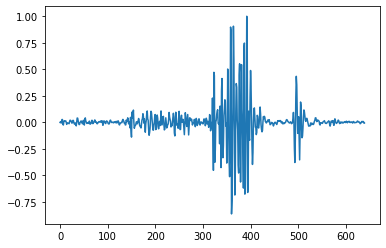

In [476]:
%matplotlib inline
print(df_features.loc[3].feature.shape)
import matplotlib.pyplot as plt
plt.plot(df_features.loc[3].feature)

In [467]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(df_features.feature.tolist())
y = np.array(df_features.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [468]:
x_train.shape

(1225, 640, 1)

In [469]:
#x_train = np.expand_dims(x_train, axis=2)
#x_test = np.expand_dims(x_test, axis=2)

In [470]:
x_train.shape

(1225, 640, 1)

In [471]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 


num_labels = yy.shape[1]

# Construct model 
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
model = Sequential()	

model.add(Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(150, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [479]:
#DEMO
model = Sequential()	

model.add(Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(48, kernel_size=3, activation='relu'))
model.add(Conv1D(120, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [480]:
# Display model architecture summary 
model.summary()
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]
print("Pre-training accuracy: %.4f%%" % accuracy) 


Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_305 (Conv1D)          (None, 638, 8)            32        
_________________________________________________________________
conv1d_306 (Conv1D)          (None, 636, 48)           1200      
_________________________________________________________________
conv1d_307 (Conv1D)          (None, 634, 120)          17400     
_________________________________________________________________
max_pooling1d_300 (MaxPoolin (None, 211, 120)          0         
_________________________________________________________________
dropout_302 (Dropout)        (None, 211, 120)          0         
_________________________________________________________________
flatten_65 (Flatten)         (None, 25320)             0         
_________________________________________________________________
dense_133 (Dense)            (None, 128)             

In [ ]:
#https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 200

es = EarlyStopping(monitor='val_loss', patience=5)
ch = ModelCheckpoint(filepath='data/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
callbacks = [es, ch]
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, 
          epochs=num_epochs, 
          validation_data=(x_test, y_test), 
          verbose=1,
          callbacks=callbacks)


duration = datetime.now() - start
print("Training completed in time: ", duration)


In [474]:
path_weights = 'data/weights.best.basic_cnn.hdf5'
model.load_weights(path_weights)

# Evaluating the model on the training and testing set
score_t = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score_t[1])

score_v = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score_v[1])

Training Accuracy:  0.872653067111969
Testing Accuracy:  0.8045602440834045


In [244]:
df_test_ = pd.read_csv(path_test)
df_test = df_test_.copy()
df_test['filename'] = df_test['filename'].map(lambda x: 'data/data/%04d.wav' % x)
print(len(df_test.index))
df_test.head(2)

1551


,filename
0,data/data/0001.wav
1,data/data/0002.wav


In [245]:
features = []
for k,row in df_test.iterrows():
    data = extract_features(row['filename'])
    features.append([data])
df_features_test = pd.DataFrame(features, columns=['feature'])
print('Finished feature extraction from ', len(df_features_test), ' files')


Finished feature extraction from  1551  files


In [246]:
X_test = np.array(df_features_test.feature.tolist())
X_test = np.expand_dims(X_test, axis=2)

In [247]:
y_prob = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)


In [248]:
len(X_test)

1551

In [249]:
y_classes

array([0, 0, 0, ..., 0, 0, 0])

In [250]:
df_test_['label'] = y_classes

In [251]:
from datetime import datetime
now = datetime.now() # current date and time
timestamp = now.strftime("%Y%m%d_%H%M%S")
model_json = model.to_json()
model.save_weights('data/%s_weights.hdf5' % timestamp)
with open("data/%s_model.json" % timestamp, "w") as json_file:
    json_file.write(model_json)
df_test_.to_csv('data/%s_res.csv' % timestamp, index=None, header=None)
with open("data/%s_score.txt" % timestamp, "w") as file:
    scoring = "validation acc: %f - training acc: %f - sample rate: %i" % (score_v[1], score_t[1], sample_rate)
    file.write(scoring)

timestamp

'20191107_000440'